# 05c parameter optimisation 

In [30]:
#|default_exp core.05c_parameter_optimisation

In [31]:
#|export
import autograd.numpy as np
from autograd import grad, jacobian, hessian
#from scipy.special import logsumexp
from scipy.optimize import minimize
import pandas as pd
from matplotlib import pyplot as plt

from dementia_inequalities import const, log, utils, tools 

---

In [32]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [33]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.226918,48.025165,34.275376,60.412434,19.073111,6.164929,2.948652,215.158147,0.001420
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.648147,72.016965,20.177787,64.559886,10.372597,3.650571,1.287952,437.450820,0.002790
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.922160,55.139862,23.752404,62.659322,13.584680,4.848008,1.987987,123.466346,0.001299
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.996946,53.341341,23.914299,58.934576,13.640026,5.506448,2.148768,612.399689,0.004970
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.805733,48.818156,29.486050,62.572808,15.965501,6.298085,2.250735,77.360723,0.001138


In [34]:
# The real dementia x and y data 

# covariates 
covar = ['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']

# Input data 
x = np.array(df_dem_plus[covar].values.reshape(-1,7))

# Outcome data 
y = np.array(df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1))

In [35]:
def reverse_shift_log_normal_pdf(x, delta, mu, sigma):
    pdf = []
    #x_shift = delta - x
    for i, x_i in enumerate(x):
        #if isinstance(delta, int) or isinstance(delta, float):
        #    delta = delta * np.ones(len(x)).T  

        #if x_shift[i] < 0: 
        if delta[i] < x_i: 
            pdf.append(0)
        else: 
            x_shift = delta[i] - x_i
            norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
            exp_part = np.exp(-1 * (1 / (2 * sigma ** 2)) * (np.log(np.subtract(x_shift, mu)) ** 2))
            #exp_part = np.exp(-(np.log(np.subtract(x_shift, mu)) ** 2))
            pdf.append(norm_const.squeeze() * exp_part.squeeze())
            
    return np.array(pdf)

In [36]:
def log_rvs_shift_log_normal(z, delta, mu, sigma):
    pdf = []
    z_shift = np.array(delta - z)
    for i in range(len(z_shift)):
        if z_shift[i]>0: 
            part1 = (1/(2 * sigma ** 2)) * (2 * mu * np.log(z_shift[i]) - (np.log(z_shift[i])) ** 2 - mu ** 2) 
            part2 = np.log(z_shift[i] * sigma * np.sqrt(2 *np.pi))
            pdf.append(part1 - part2)
        else:
            pdf.append(np.log(0))
    return np.array(pdf)

def neg_loglike(params):
    beta_0 = params[0]
    beta = np.array(params[1:-2])
    mu = params[-2]
    sigma = params[-1]

    y_pred = (np.dot(x, beta)).squeeze() + beta_0
    log_likely = log_rvs_shift_log_normal(y.squeeze(), delta=y_pred.squeeze(), mu=mu, sigma=sigma)
    
    return (-1 * np.sum(log_likely)).squeeze()

In [37]:
def log_norm_mode(mu:int, # mean of the variables log
                  sigma:int): # standard deviation of the variables log
    return np.exp(mu - sigma**2)

In [54]:
trial_params = np.array([0.25, 0.1, 0.004, -0.004, -0.003, 0.0157, -0.0138, 0.108, 0.0, 0.25])
print(neg_loglike(trial_params))

1456.266249108371


In [58]:
jacobian_ = jacobian(neg_loglike)

print(jacobian_(trial_params))

[  1768.67745796  44618.02814593 111641.54133364  88739.19989015
 143478.93221752  26369.373887    10600.19537135   3514.11767471
  -3498.67903534  -9820.0940818 ]


### Optimise the negative log likelihood 

We evaluate the log-likelihood using the maximise function from scikit-learn. This code is written with a little help from my firend ChatGPT - actually it generated the intial code - then I re-wrote 70% of it... 

*Note*: we need the likelihood to be the shifted log normal - which has an extra parameter (delta) compared to the log normal [see here](https://stats.stackexchange.com/questions/379980/understanding-the-shifted-log-normal-distribution). 

The shifted log-normal PDF at $x$ is: 

$$
p(x|x>\delta, \delta, \mu, \sigma) = 
\frac{1}{(x-\delta)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(x- \delta)-\mu)^2}
$$

In the log-normal distribution, 
- $\mu$ is the scale parameter - it stretches and compresses
- $\sigma$ is a shape parameter - it controls how skewed/heavy tailed the distribution is. 
- $\delta$ is the shift parameter - here the shift is the linear equation: $\delta = \beta X$.

Since, we are taking $y_i$ to represent the observed diagnoses, and $\beta X$ to represent the expected a lower bound on the true prevalence rate the equation is: 

$$
y_i=\beta X_i - \epsilon 
$$ 

Where $\epsilon > 0$. Now, accordingly the probability is: 

$$
p(y_i|y_i < \beta X_i, \beta, \mu, \sigma) = 
\frac{1}{(\beta X_i - y_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(\beta X_i - y_i)-\mu)^2}
$$

And hence, the likelihood is: 

$$
L(\delta, \mu, \sigma) = \prod_{i=1}^n s(y_i | y_i < \beta X, \beta X, \mu, \sigma) \\

= \prod_{i=1}^n \frac{1}{(\beta X_i - y_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(\beta X_i - y_i)-\mu)^2}
$$

Let $ z_i = \beta X_i -y_i $. Then we have a log likelihood of:

$$
= \sum_{i=1}^n ln(\frac{1}{z_i \sigma \sqrt{2 \pi}} exp(- \frac{(ln z_i - \mu)^2}{2 \sigma^2})) \\ 
= \sum_{i=1}^n ln(\frac{1}{z_i \sigma \sqrt{2 \pi}} ) - \frac{ln^2z_i -2\mu ln z_i + \mu^2}{2 \sigma^2} \\
= \sum_{i=1}^n - ln(z_i \sigma \sqrt{2 \pi}) - \frac{1}{2 \sigma^2}(ln^2z_i -2\mu ln z_i + \mu^2) \\
= \sum_{i=1}^n \frac{1}{2 \sigma^2}(2\mu ln z_i - ln^2 z_i - \mu^2) - ln(z_i \sigma \sqrt{2 \pi})
$$


/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_65731/1017857730.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_65731/1017857730.py:16: RuntimeWarning: invalid value encountered in scalar multiply
  pdf.append(norm_const.squeeze() * exp_part.squeeze())


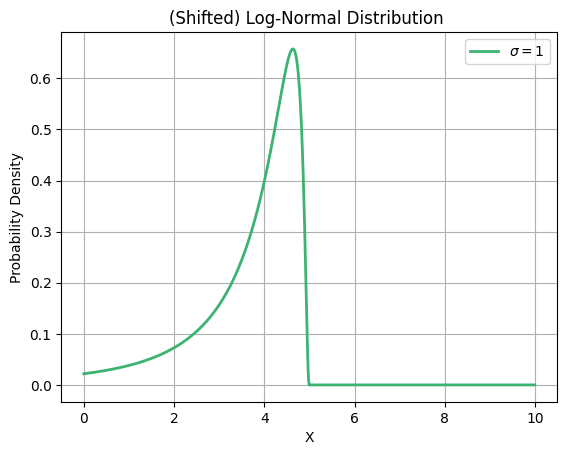

In [40]:
# Parameters for log-normal distribution
mu_0 = 0  # Mean
sigma_0 = 1
shift = 5 # Shift 

x_axis = np.arange(0, 10, 0.01)
shift = shift * np.ones(len(x_axis))

pdf_x_mu0 = reverse_shift_log_normal_pdf(x_axis, shift, mu_0, sigma_0)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x_axis, pdf_x_mu0, '-', linewidth=2, color='mediumseagreen', label='$\sigma=1$')
#plt.text(6, 0.42, '$\sigma=1$', color='mediumseagreen')
#plt.plot(x, pdf_x_mu1, '-', linewidth=2, color='slateblue', label='$\sigma=0.25$')
#plt.text(7, 0.15, '$\sigma=0.25$', color='slateblue')

plt.title('(Shifted) Log-Normal Distribution ')
plt.legend(loc='upper right')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [41]:
# n_features = 7

# np.random.seed(27)
# x0 = np.concatenate([np.random.normal(size=n_features+1), [0, 0.25]]) 

params_0 = np.array([0.25, 0.1, 0.004, -0.004, -0.003, 0.0157, -0.0138, 0.108, 0.1, 0.25])

In [42]:
# Gradient of the function
#grad_loglike = grad(neg_loglike)

# Initial guess

# Use scipy's minimize function with the BFGS algorithm
result = minimize(neg_loglike, params_0, method = 'BFGS')

result

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/scipy/o

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -298.2355404837039
        x: [ 1.273e+01  1.479e-02 -7.729e-04 -3.468e-04 -4.286e-04
             2.006e-02 -2.567e-02  1.304e-01  2.534e+00  7.310e-03]
      nit: 401
      jac: [ 6.130e-03  6.122e-01  1.620e+00  1.279e+00  2.077e+00
             3.240e-01  1.404e-01  4.014e-02 -3.960e-01 -5.729e-02]
 hess_inv: [[ 2.352e-04  1.614e-05 ... -1.183e-05  1.122e-06]
            [ 1.614e-05  3.208e-06 ... -6.845e-07  8.137e-08]
            ...
            [-1.183e-05 -6.845e-07 ...  7.983e-07 -5.889e-08]
            [ 1.122e-06  8.137e-08 ... -5.889e-08  6.379e-08]]
     nfev: 6577
     njev: 596

In [43]:
# derivates of neg_loglike
jacobian_  = jacobian(neg_loglike)

#result = minimize(neg_loglike, params_0, method = 'BFGS', \
#               options={'disp': False}, jac = jacobian_)


result = minimize(neg_loglike, params_0, method='BFGS', jac = jacobian_, options={'gtol': 1e-6, 'disp':True})
result

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/s

         Current function value: -298.611695
         Iterations: 2000
         Function evaluations: 2556
         Gradient evaluations: 2547


/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: -298.61169456193755
        x: [ 7.331e+01  1.474e-02 -7.515e-04 -3.408e-04 -4.242e-04
             2.005e-02 -2.552e-02  1.303e-01  4.293e+00  1.258e-03]
      nit: 2000
      jac: [-5.467e-01 -1.332e+01 -3.442e+01 -2.778e+01 -4.291e+01
            -7.960e+00 -3.241e+00 -1.052e+00  3.994e+01 -8.257e-02]
 hess_inv: [[ 1.213e+02  1.222e-04 ...  1.658e+00 -2.087e-03]
            [ 1.222e-04  8.435e-06 ... -2.012e-07  1.315e-10]
            ...
            [ 1.658e+00 -2.012e-07 ...  2.266e-02 -2.852e-05]
            [-2.087e-03  1.315e-10 ... -2.852e-05  3.837e-08]]
     nfev: 2556
     njev: 2547

In [44]:
# Extract the MLE from the parameter samples
MLE_params = result.x

MLE_intercept = MLE_params[0]
MLE_beta = MLE_params[1:-2]
MLE_mu = MLE_params[-2]
MLE_sigma = MLE_params[-1]

print("MLE estimates \n--------------\n--------------")
print(f'Intercept:{MLE_intercept}')
print("--------------\nRegression coefficients\n--------------")
for i, var in enumerate(covar):
    print(f'{var}:{MLE_beta[i]}')
print("--------------\nLog normal coefficients\n--------------")
print("Mu:", MLE_mu)
print("Sigma:", MLE_sigma)

MLE estimates 
--------------
--------------
Intercept:73.31040660047536
--------------
Regression coefficients
--------------
over_65_pc:0.014741074756822369
female_pc:-0.0007514953561307034
ALevel_plus_pc:-0.00034080692297835995
white_pc:-0.00042424406201616927
HYP_afflicted_pc:0.020052723797070165
DM_afflicted_pc:-0.025519650423937536
STIA_afflicted_pc:0.13025776353682317
--------------
Log normal coefficients
--------------
Mu: 4.293103835601994
Sigma: 0.0012577596188672224


/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


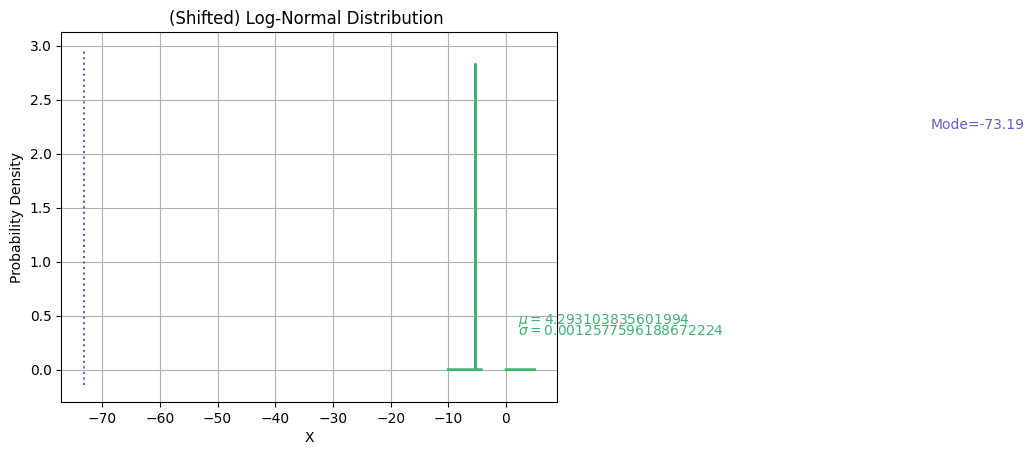

In [45]:
# mode of the log normal 
mode = log_norm_mode(MLE_mu, MLE_sigma)

# plot log normal of MLE parameters 
x_axis = np.arange(-10, 5, 0.01)
pdf_x_mu0 = reverse_shift_log_normal_pdf(x_axis, np.zeros(len(x_axis)), MLE_mu, MLE_sigma)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x_axis, pdf_x_mu0, '-', linewidth=2, color='mediumseagreen')
plt.text(2.1, 0.32, f'$\sigma=${MLE_sigma}', color='mediumseagreen')
plt.text(2.1, 0.42, f'$\mu=${MLE_mu}', color='mediumseagreen')
#plt.text(7, 0.15, '$\sigma=0.25$', color='slateblue')

ymin, ymax = plt.ylim()
plt.vlines(-mode, ymin, ymax, color='slateblue', label='Log normal mode', linestyles='dotted')
plt.text(mode+0.5, 3*ymax/4, f'Mode={np.round(-mode,2)}', color='slateblue')

plt.title('(Shifted) Log-Normal Distribution ')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [46]:
y_pred = np.dot(x, MLE_beta.T) + MLE_intercept
diagnosis_gap = y_pred.squeeze() - y.squeeze()

# update the dataframe 
df_dem_plus['diagnosis_gap']=diagnosis_gap

In [47]:
y_pred

array([74.32358184, 73.79066437, 73.96658203, 73.97610306, 74.09421044,
       73.76938532, 73.92768   , 74.02315298, 74.10860519, 73.87413086,
       73.96688012, 73.96733664, 73.93194774, 74.25246756, 73.97284082,
       74.05695247, 74.15395642, 73.92571045, 73.93771248, 74.04953883,
       73.67653803, 73.5808658 , 73.96318886, 74.05091628, 74.18373137,
       74.07729638, 73.87075193, 74.174217  , 74.12916697, 74.31477114,
       73.97023628, 74.22451184, 73.62140518, 74.14625458, 73.77848139,
       74.28221852, 74.03002237, 73.83221275, 74.23114245, 73.84427792,
       74.23660025, 73.5682898 , 73.69847718, 73.83704703, 73.96913866,
       73.94030403, 73.8380402 , 74.08395722, 73.62012456, 74.05995838,
       74.0773741 , 73.6704677 , 73.82742523, 73.8476527 , 73.94549257,
       74.05784778, 74.29594088, 73.86536071, 73.67337201, 74.16659402,
       73.89203139, 74.11048783, 73.42025623, 74.16286799, 73.90052853,
       73.81796271, 74.0706312 , 73.86436061, 73.92708357, 73.82

In [48]:
most_bad_lads = np.argsort(diagnosis_gap)[-10:]
df_dem_plus.iloc[most_bad_lads, :][['area_name', 'diagnosis_gap']]

,area_name,diagnosis_gap
107,Cornwall,73.360257
60,Worcester,73.362231
79,Wychavon,73.363167
286,Torridge,73.363814
134,Scarborough,73.364718
294,Nuneaton and Bedworth,73.367733
75,Redditch,73.379476
283,City of London,73.403249
40,South Hams,73.429785
271,Eden,73.435635


In [49]:
least_bad_lads = np.argsort(diagnosis_gap)[:10]
df_dem_plus.iloc[least_bad_lads, :][['area_name', 'diagnosis_gap']]

,area_name,diagnosis_gap
77,Rochford,72.849432
29,East Devon,72.932403
123,Surrey Heath,72.940172
196,East Hampshire,72.944682
63,Eastbourne,72.953862
225,Southampton,72.959516
10,Southend-on-Sea,72.973014
3,Lancaster,72.979157
99,Tendring,72.989706
138,Ashfield,72.991756


## Evaluating the Fisher information at the MLE 

In [50]:
hessian_ = hessian(neg_loglike)

print(hessian_(MLE_params))

[[ 3.64605236e+04  8.88299806e+05  2.29563680e+06  1.85252930e+06
   2.86199798e+06  5.30875360e+05  2.16152187e+05  7.01386037e+04
  -2.66865425e+06  7.58232669e+03]
 [ 8.88299806e+05  2.28414583e+07  5.58195067e+07  4.45040926e+07
   7.29836466e+07  1.33896164e+07  5.33193734e+06  1.80212995e+06
  -6.50172964e+07  1.84730541e+05]
 [ 2.29563680e+06  5.58195067e+07  1.44922191e+08  1.16677226e+08
   1.79628312e+08  3.33890996e+07  1.36274007e+07  4.40017189e+06
  -1.68024494e+08  4.77400378e+05]
 [ 1.85252930e+06  4.45040926e+07  1.16677226e+08  9.63427059e+07
   1.43155159e+08  2.65251831e+07  1.07765777e+07  3.49326928e+06
  -1.35592137e+08  3.85251899e+05]
 [ 2.86199798e+06  7.29836466e+07  1.79628312e+08  1.43155159e+08
   2.37536507e+08  4.29741318e+07  1.70755836e+07  5.78476143e+06
  -2.09478122e+08  5.95180673e+05]
 [ 5.30875360e+05  1.33896164e+07  3.33890996e+07  2.65251831e+07
   4.29741318e+07  7.95469644e+06  3.20121864e+06  1.06127031e+06
  -3.88563444e+07  1.10400619e+05

In [51]:
def is_neg_def(x):
    return np.all(np.linalg.eigvals(x) <= 0)

In [52]:
np.linalg.eigvals(hessian_(MLE_params))

array([6.93606993e+08, 3.90653428e+08, 1.08325879e+07, 1.38332959e+06,
       3.81744020e+05, 1.82230053e+05, 2.81496316e+04, 5.24547973e+03,
       7.48059162e-03, 9.03385549e+02])

In [53]:
is_neg_def(hessian_(MLE_params))

False